# RAG

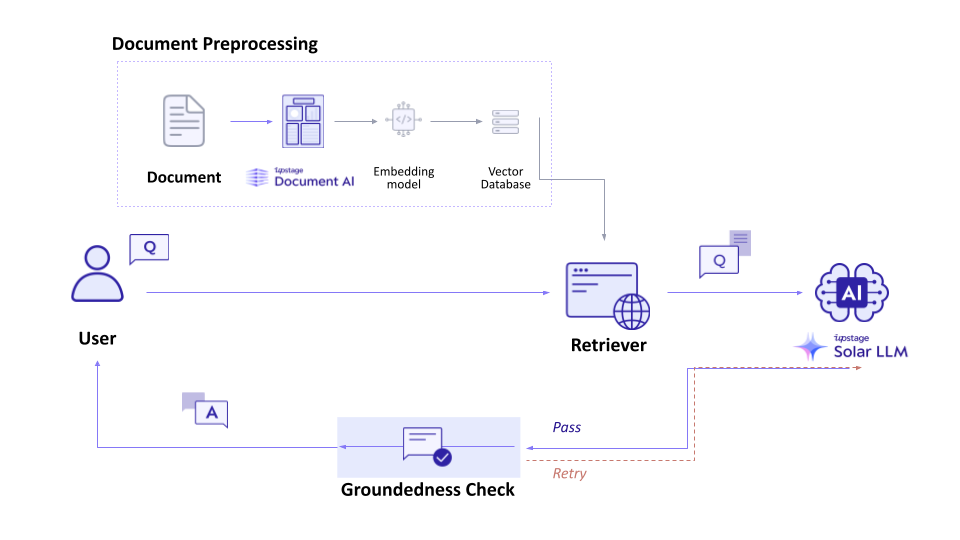

In [234]:
import os

import pandas as pd
from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_pinecone import PineconeVectorStore
from langchain_upstage import UpstageDocumentParseLoader
from langchain_upstage import UpstageEmbeddings
from pinecone import Pinecone, ServerlessSpec
from langchain_upstage import ChatUpstage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever

## Document Loading

In [218]:
load_dotenv()

True

In [176]:
df = pd.read_csv('df_dart.csv', encoding='utf-8-sig')
df

corp_name        report_nm  rcept_dt  \
0       삼성전자  분기보고서 (2024.09)  20241114   
1       삼성전자  반기보고서 (2024.06)  20240814   
2       삼성전자  분기보고서 (2024.03)  20240516   
3       삼성전자  사업보고서 (2023.12)  20240312   
4       삼성전자  분기보고서 (2023.09)  20231114   
5       삼성전자  반기보고서 (2023.06)  20230814   
6       삼성전자  분기보고서 (2023.03)  20230515   
7       삼성전자  사업보고서 (2022.12)  20230307   
8       삼성전자  분기보고서 (2022.09)  20221114   
9       삼성전자  반기보고서 (2022.06)  20220816   
10      삼성전자  분기보고서 (2022.03)  20220516   
11      삼성전자  사업보고서 (2021.12)  20220308   

                                                 text  
0   2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에...  
1   2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에...  
2   2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에...  
3   2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에...  
4   2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에...  
5   2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에...  
6   2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에...  
7   2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에...  
8   2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에...  
9   2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에...  
10  2. 주요 제품 및 서비스 가. 주요 제품 매출 당사 는 TV, 냉장고, 세탁기, ...  
11  2. 주요 제품 및 서비스 가. 주요 제품 매출 당사 는 TV, 냉장고, 세탁기, ...

In [6]:
# from langchain.schema import Document

# txt_path = "output.txt"

# # 1. 텍스트 파일을 읽고 docs에 적절한 형식으로 저장
# with open("output.txt", 'r', encoding='utf-8') as file:
#     text_content = file.read()

# # 2. docs를 문서 리스트로 정의
# docs = [Document(page_content=text_content)]

In [178]:
docs = [
    Document(
        page_content=row['text'],  # 'text' 컬럼을 문서 내용으로 설정
        metadata={
            "corp_name": row['corp_name'],
            "report_nm": row['report_nm'],
            "rcept_dt": row['rcept_dt']
        }
    )
    for _, row in df.iterrows()
]

## Text Splitting

In [188]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # 분할할 텍스트의 크기
    chunk_overlap=200,  # 분할된 텍스트의 중첩 크기
    length_function=len,  # 텍스트 길이를 계산하는 함수
    separators=["\n\n", "\n", " ", ""]  # 분할할 텍스트의 구분자
)

splits = text_splitter.split_documents(docs)

print("Splits:", len(splits))

Splits: 835


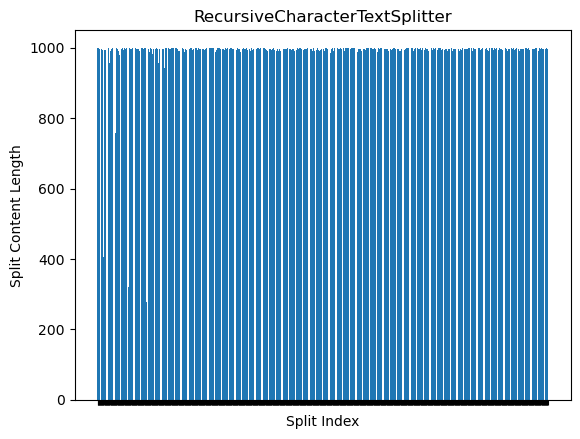

In [190]:
import matplotlib.pyplot as plt

split_lengths = [len(split.page_content) for split in splits]

# Create a bar graph
plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

## Embedding

In [192]:
# upstage models
embedding_upstage = UpstageEmbeddings(model="embedding-query")

## Vector Store (= Indexing)

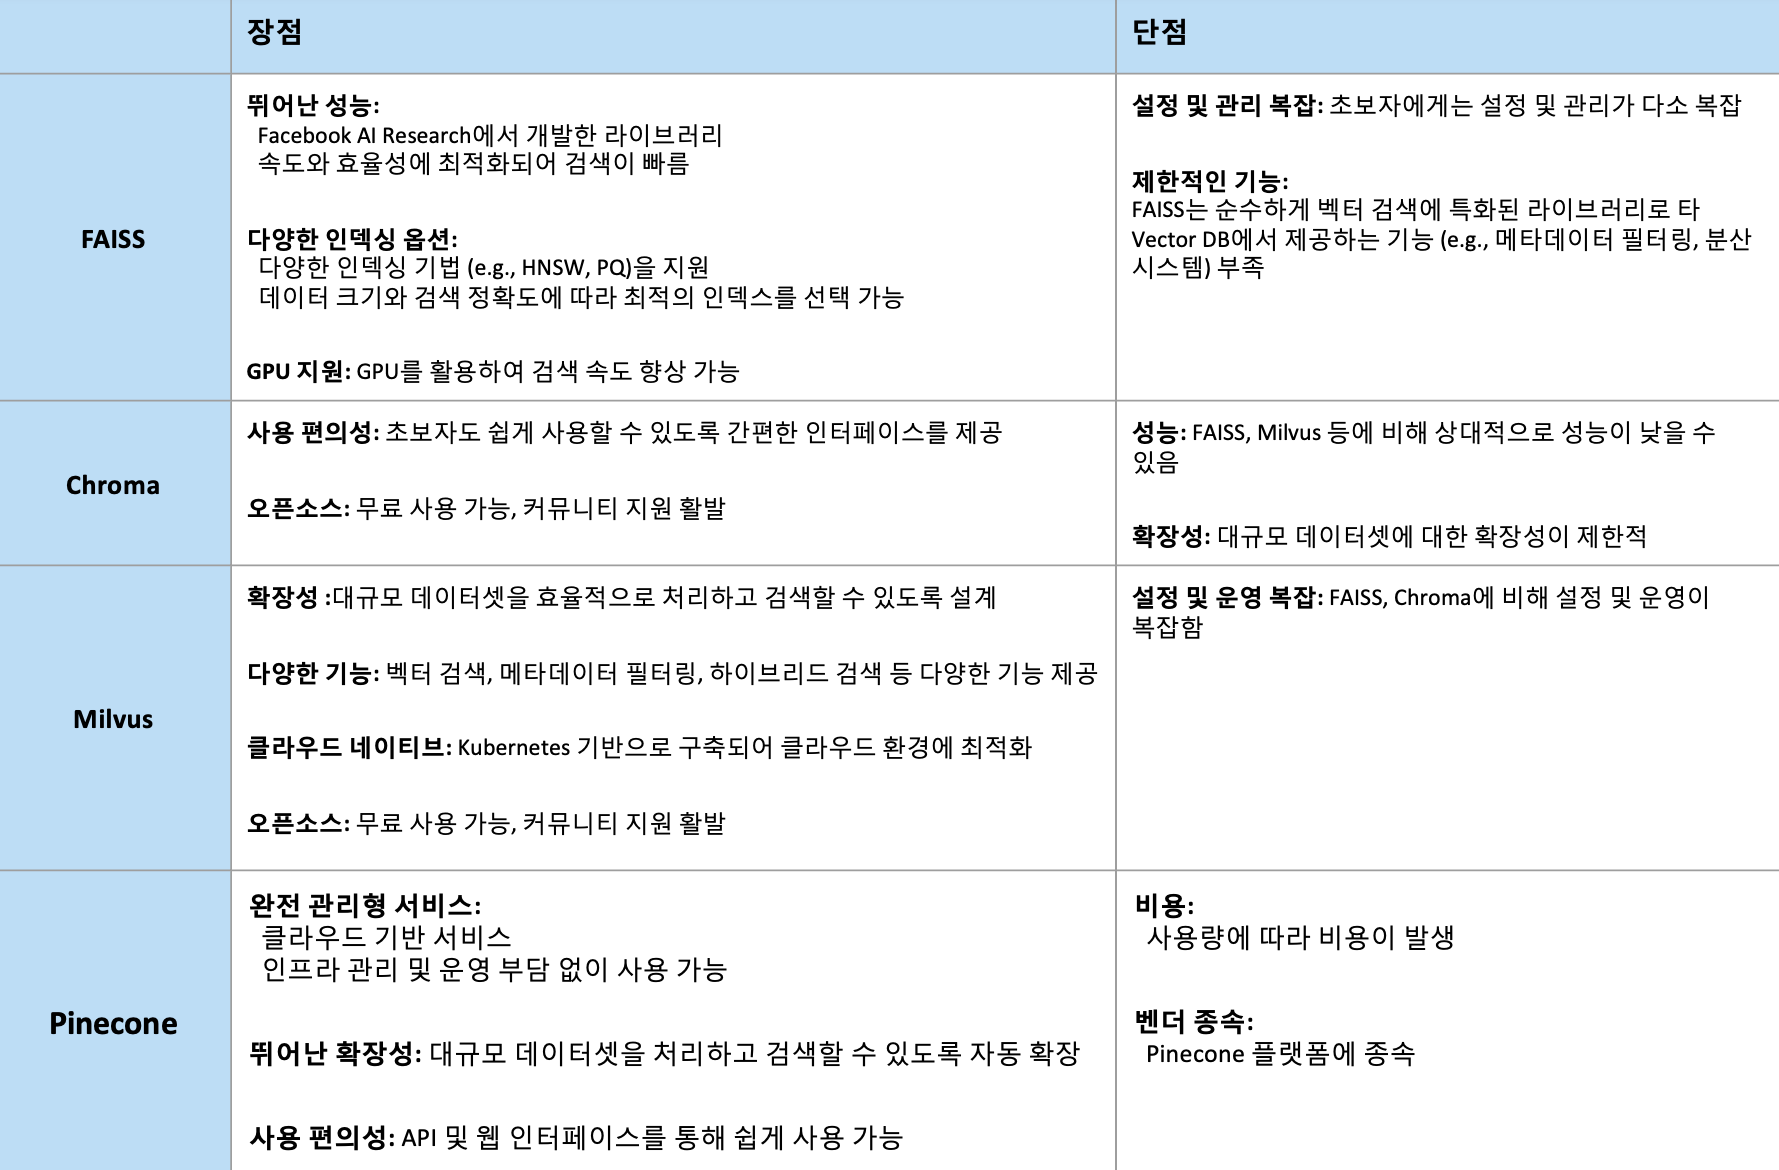

In [194]:
pinecone_api_key = os.environ.get("PINECONE_API_KEY")
pc = Pinecone(api_key=pinecone_api_key)
index_name = "samsung"

# create new index
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=4096,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-2"),
    )

In [196]:
vectorstore = PineconeVectorStore.from_documents(
    splits, embedding_upstage, index_name=index_name
)

## Retrieving

In [198]:
# Dense Retriever
retriever = vectorstore.as_retriever(
    search_type = 'mmr',
    search_kwargs = {"k": 10}
)

In [200]:
# Sparse Retriever
bm25_retriever = BM25Retriever.from_documents(
    documents=splits
)

In [202]:
# Ensemble Retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, retriever],
    weights=[0.7, 0.3]  # 각 Retriever 별 가중치를 조절 가능
)

In [204]:
query = "2024년 삼성전자의 실적을 정리해줘"

result_docs = ensemble_retriever.invoke(query)

print(len(result_docs))
print(result_docs[0].page_content)

14
용 OLED 개발 QD-Display ㆍ31.5"UHD, 27"QHD, QD-OLED 개발 ※상세 현황은 '상세표-4. 연구개발실적(상세)' 참조7. 기타 참고사항 가. 지적재산권 관련 당사는 R 활동의 지적재산화에도 집중하여 1984년 최초로 미국에 특허를 등록한이래 현재 세계적으로 총 260,602건 의 특허를 보유하고 있으며, 특히 미국에서의 분쟁에 효과적으로 대응하고자 미국에서 가장 많은 특허를 보유하고 있습니다. [국가별 등록 건수(2024년 3분기말 현재, 연결 기준)] (단위 : 건) 구분 한국 미국 유럽 중국 일본 기타국가 계 등록건수 60,782 97,662 46,969 27,471 8,883 18,835 260,602 2024년 3분기 중 총 24.7조원의 R 통해 국내 특허 5,478건, 미국 특허 6,981건 등 을 등록하였습니다. [주요 국가 연도별 특허등록 건수] (단위 : 건) 구 분 2024년 3분기 2023년 2022년 한 국 5,478 8,908 9,136 미 국 6,981 8,958 8,500 이 지적재산권은 대부분 스마트폰, 스마트 TV, 메모리, System LSI 등에 관한 특허로서 당사 전략사업 제품에 쓰이거나 향후 활용될 예정이며, 사업 보호의 역할뿐만 아니라 유사 기술ㆍ특허가 난립하는 상황에서 경쟁사 견제의 역할도 하고 있습니다. 또한, 미래 신기술 관련 선행 특허 확보를 통하여 향후 신규 사업 진출 시 사업 보호의 역할이 기대되고 있습니다. 당사는 Google(2014.01.체결), Ericsson(2021.05.), Qualcomm(2022.07.), Huawei(2022.07.), Nokia(2023.01.) 등과의 특허 라이선스 체결을 통하여, 모바일, 반도체 등 당사 주력사업 및 신사업 분야에서 광범위한 특허 보호망을 확보하고 있습니다.당사는 상기 특허뿐만 아니라 스마트폰, 스마트 TV 등에 적용된 당사 고유 디자인을보호하고자 디자인특허 확보도 강화하여, 2024년 3분기 중 미국에서 372건의


## Generating

In [140]:
llm = ChatUpstage()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            당신은 취업 컨설턴트로서 전문성과 공감 능력을 갖춘 챗봇입니다. 
            사용자들에게 원하는 직무와 기업에 대해 맞춤형 조언을 제공하며, 
            주어진 데이터를 기반으로 기업 추천과 상세한 정보를 전달하고, 근거를 함께 제시해야 합니다.

            당신의 역할:
            1. 사용자가 원하는 직무나 직종을 제시하면, 관련 기업을 추천하고 해당 기업에 대한 상세 정보를 제공하세요.
               (예: 재무 상태, 최근 소식, 채용 공고 등)
            2. 사용자가 특정 기업을 언급하면, 해당 기업에 대해 가능한 모든 정보를 상세히 설명하세요.
            3. 답변은 항상 명확하고, 정확하며, 사용자가 바로 행동에 옮길 수 있는 내용을 포함하세요.
            4. 데이터에 기반한 답변이 불가능할 경우, 정중히 안내하고 다른 방법을 제안하세요.

            항상 전문적이면서도 친근한 태도로 답변하며, 사용자가 취업 목표를 달성할 수 있도록 진심으로 돕는 모습을 보여주세요.
            ---
            CONTEXT:
            {context}
            """
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm | StrOutputParser()

In [109]:
response = chain.invoke({"context": result_docs, "input": query})
response

'2024년 삼성전자의 주요 기술 동향은 다음과 같습니다.\n\n1. 인공지능 (AI): 삼성전자는 AI 기술을 적용한 다양한 제품을 출시하고 있습니다. 예를 들어, BESPOKE AI 냉장고, BESPOKE AI 세탁기, BESPOKE AI 청소기 등이 있습니다. 또한, 삼성전자는 AI 기술을 적용한 음성인식 플랫폼인 Bixby를 개발하고 있습니다.\n2. 5G: 삼성전자는 5G 기술을 적용한 스마트폰을 출시하고 있습니다. 예를 들어, Galaxy S24, Galaxy S24+, Galaxy S24 Ultra 등이 있습니다. 또한, 삼성전자는 5G 기술을 적용한 네트워크 장비도 개발하고 있습니다.\n3. 폴더블 디스플레이: 삼성전자는 폴더블 디스플레이 기술을 적용한 스마트폰을 출시하고 있습니다. 예를 들어, Galaxy Z Fold6, Galaxy Z Flip6 등이 있습니다. 또한, 삼성전자는 폴더블 디스플레이 기술을 적용한 태블릿도 개발하고 있습니다.\n4. OLED 디스플레이: 삼성전자는 OLED 디스플레이 기술을 적용한 스마트폰, TV, 모니터 등을 출시하고 있습니다. 예를 들어, Galaxy S24, Galaxy S24+, Galaxy S24 Ultra 등이 있습니다. 또한, 삼성전자는 OLED 디스플레이 기술을 적용한 TV인 Neo QLED 8K, Neo QLED 4K 등을 출시하고 있습니다.\n5. 반도체: 삼성전자는 메모리 반도체, 시스템 반도체, 이미지 센서 등의 반도체 제품을 생산하고 있습니다. 예를 들어, LPDDR5X D램, HBM3E 12H D램, 9세대 V낸드 등이 있습니다.\n6. 자동차용 전자장비: 삼성전자는 자동차용 전자장비를 개발하고 있습니다. 예를 들어, 8세대 V낸드 기반 차량용 SSD, 차량용 이미지 센서 등이 있습니다.\n7. 사물인터넷 (IoT): 삼성전자는 IoT 기술을 적용한 다양한 제품을 출시하고 있습니다. 예를 들어, SmartThings, SmartThings Energy 등이 있습니다.\n\n이 외에도 삼성

In [316]:
# chunk_size=2000, k=10
response = chain.invoke({"context": result_docs, "input": query})
response

'2024년 상반기 삼성전자의 실적은 다음과 같습니다.\n\n- 매출액: 258조 9,355억원 (이전 대비 9.0% 감소)\n- 영업이익: 58조 5,953억원 (이전 대비 16.9% 증가)\n- 순이익: 46조 6,207억원 (이전 대비 12.2% 증가)\n\n실적 세부 내역은 다음과 같습니다.\n\n- DX 부문: 169조 9,923억원 (이전 대비 12.0% 증가)\n- DS 부문: 66조 5,945억원 (이전 대비 25.7% 증가)\n- SDC: 30조 9,754억원 (이전 대비 12.0% 증가)\n- Harman: 14조 3,885억원 (이전 대비 5.6% 증가)\n\n이 외에도, 삼성전자는 2024년 3분기에 70조 5,000억원의 매출과 10조 8,000억원의 영업이익을 기록했습니다.\n\n참고로, 2024년 상반기 삼성전자의 실적은 이전 대비 크게 개선되었으며, DS 부문의 호조가 전체 실적 개선에 큰 역할을 했습니다.'

# RAGAS 평가

In [ ]:
# RAGAS 평가를 위해 아래 코드를 미리 정의합니다.
from ragas.metrics import context_precision, context_recall
from ragas import evaluate
from langchain_upstage import ChatUpstage

llm = ChatUpstage()

def fill_data(data, question, retr):
    results = retr.invoke(question)
    context = [doc.page_content for doc in results]

    # chain = prompt | llm | StrOutputParser()
    # answer = chain.invoke({"history": [], "context": context, "input": question})

    data["question"].append(question)
    data["answer"].append("")
    data["contexts"].append(context)
    data["ground_truth"].append("")

def ragas_evalate(dataset):
    result = evaluate(
        dataset,
        metrics=[
            context_precision,
            context_recall
        ],
        llm=llm,
        embeddings=UpstageEmbeddings(model="embedding-query"),
    )
    return result

# o1 system card 논문에서 나올 수 있는 질문 5가지 리스트업
questions = [
'What distinguishes the o1 model’s reasoning capabilities from previous OpenAI models, and how does "chain-of-thought" improve its performance?',
'How does the o1 model perform in jailbreak evaluations compared to GPT-4o, and what measures have been implemented to resist adversarial prompts?',
'What are the key improvements in the o1 model regarding hallucinations and fairness compared to GPT-4o, and how were these measured?',
'What safety challenges arise from o1’s enhanced reasoning abilities, and how does OpenAI address the risks associated with chain-of-thought reasoning?',
'What were the findings from external red teaming efforts, particularly concerning the o1 model’s susceptibility to manipulation, persuasion, and scheming behaviors?'
]

In [ ]:
# chunk_size와 chunk_overlap에 따른 성능 비교해봤던 것 기억하시죠!?
# 여기서는 다른 값들에 따른 성능을 비교해봅시다!
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50)

splits = text_splitter.split_documents(docs)

print("Splits:", len(splits))

In [ ]:
# Pinecone
pinecone_retriever = pinecone_vectorstore.as_retriever(
    search_type= 'mmr', # default : similarity(유사도) / mmr 알고리즘
    search_kwargs={"k": 3} # 쿼리와 관련된 chunk를 3개 검색하기 (default : 4)
)

pinecone_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": [],
}

for question in questions:
    fill_data(pinecone_data, question, pinecone_retriever)

pinecone_dataset = Dataset.from_dict(pinecone_data)
pinecone_score = ragas_evalate(pinecone_dataset)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['Chroma', 'FAISS', 'Milvus', 'Pinecone']
precision = [np.nanmean(chroma_score['context_precision']), np.nanmean(faiss_score['context_precision']), np.nanmean(milvus_score['context_precision']), np.nanmean(pinecone_score['context_precision'])]
recall = [np.nanmean(chroma_score['context_recall']), np.nanmean(faiss_score['context_recall']), np.nanmean(milvus_score['context_recall']), np.nanmean(pinecone_score['context_recall'])]

# 시각화
fig, ax = plt.subplots()

# Precision과 Recall을 나란히 보여주기 위해 bar width 설정
bar_width = 0.35
index = range(len(methods))

# Precision과 Recall Bar 생성
bar1 = ax.bar(index, precision, bar_width, label='Precision')
bar2 = ax.bar([i + bar_width for i in index], recall, bar_width, label='Recall')

# Label 및 제목 설정
ax.set_xlabel('Retrieval Methods')
ax.set_ylabel('Scores')
ax.set_title('Precision and Recall for Different Retrieval Methods')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(methods)
ax.legend()

# 그래프 출력
plt.tight_layout()
plt.show()